In [1]:
import sys
sys.path.append('/users/varverak/src/hipace/tools/')
sys.path.append('/users/varverak/PositronPWFA/analysis/')

import defs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable

import read_insitu_diagnostics as diag

max_step = 800
r = True
n = True

# sub = 'front_initial'
# sub = 'front_initial_propagated'
# sub = 'front_initial_eta22'
# sub = 'front_initial_offset_test'
# sub = 'front_propagated_recovery_offset_1.0_sigma'
sub = 'front_propagated_recovery_offset_1.0_sigma_800_steps'
# sub = 'front_propagated_recovery_offset_0.2_sigma_800_steps'

p = f'/scratch/project_465001379/varverak/hdf5/{sub}/'
ip = f'/scratch/project_465001379/varverak/insitu/{sub}/'

In [2]:
import matplotlib.colors as mcolors
import matplotlib as mpl

formatter = plt.ScalarFormatter(useMathText=True)
formatter.set_scientific(True)
formatter.set_powerlimits((-1,1))
# plt.rc('text', usetex = True)
plt.rcParams['lines.linewidth'] = 0.65

def sci(x=False):
    ax=plt.gca()
    ax.yaxis.set_major_formatter(formatter)

    if x:
        ax.xaxis.set_major_formatter(formatter)
    
    return ax

def customCMAP(names = ['RdBu', 'PuOr', 'PRGn', 'bwr_r', 'PuOr_r', 'seismic_r'], ncolors: int = 256):

        for cmap in names:
            # if custom version of cmap already exists, skip it
            if cmap + 'T' in plt.colormaps():
                continue
            else:
                # create the colormap
                color_array = plt.get_cmap(cmap)(range(ncolors))
                color_array[:,-1] = abs(np.linspace(-1.0, 1.0, ncolors))
                map_object = mcolors.LinearSegmentedColormap.from_list(name = cmap + 'T', colors = color_array)
                mpl.colormaps.register(cmap = map_object)

customCMAP()

### Correctly initialize insitu diagnostics due to parallel compute

In [ ]:
data = defs.Functions(path = p, insitu_path = ip, n0 = 5e16, iteration = 0, normalized = n, recovery = r, mesh_refinement = True, src_path = '/users/varverak/src/hipace/')

p_driveInsitu = {step: data.diag.read_file(ip + f'reduced_drive.{step:04}.txt') for step in range(max_step)}
p_witnessInsitu = {step: data.diag.read_file(ip + f'reduced_witness.{step:04}.txt') for step in range(max_step)}
p_recoveryInsitu = {step: data.diag.read_file(ip + f'reduced_recovery.{step:04}.txt') for step in range(max_step)}
p_fieldInsitu = {step: data.diag.read_file(ip + f'reduced_fields.{step:04}.txt') for step in range(max_step)}
time = [p_driveInsitu[step]['time'] * data.kp_inv for step in range(max_step)]

### XYZ

In [6]:
spec = 'witness'
iteration = 50
x,y,z = data.ts.get_particle(species=spec, var_list = ['x','y','z'], iteration = iteration)

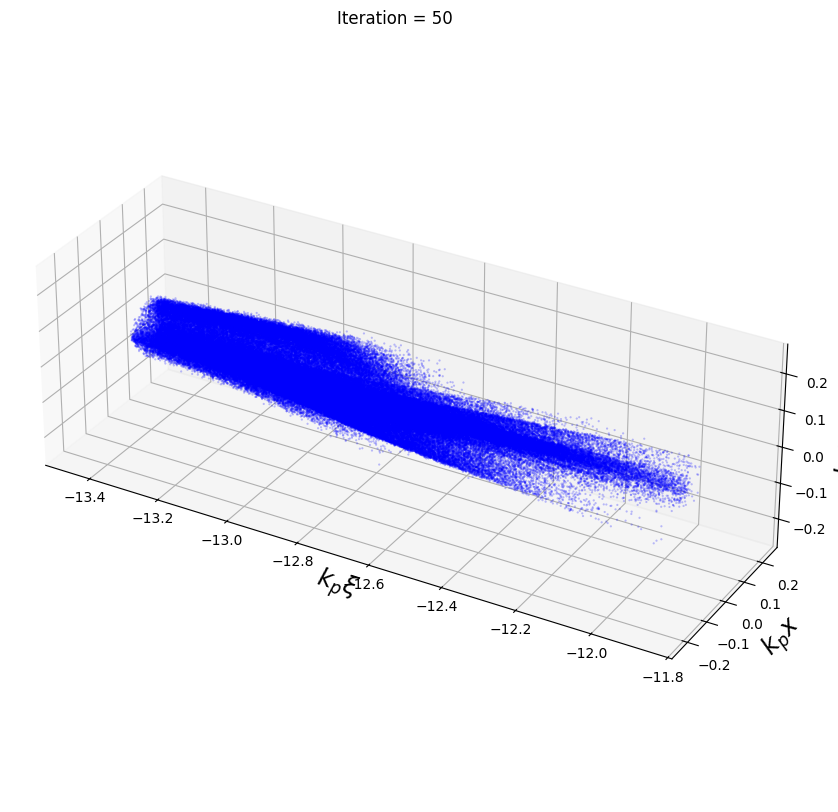

In [7]:
lim = 0.28 # 0.18
increment = int(1000)

plt.close()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,10))

ax.scatter(z[::increment], x[::increment], y[::increment], c='b', alpha=0.25, marker='o', s=2.5, edgecolors='none')

# ax = sci(x=True)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
ax.set_aspect('equal')
# ax.set_aspect('equalyz')

ax.set_xlabel('$k_p\\xi$', fontsize = 18)
ax.set_ylabel('$k_px$', fontsize = 18)
ax.set_zlabel('$k_py$', fontsize = 18)

# cb = plt.colorbar(img, ax=ax, pad=0.02, extend='max')
# cb.formatter.set_useMathText(True)
# cb.formatter.set_powerlimits((0, 0))
# cb.set_label('Particle density', fontsize=13)

plt.title(f'Iteration = {iteration}')

plt.show()

In [4]:
# Look at the number of particles within, e.g., 6 sigma_x of the (a) origin, and (b) transverse centroid

spec = 'witness'
sigma_x = 0.03
n = 6

particle_weights_origin = []
particle_weights_centroid = []

for iteration in data.ts.iterations:
    x_origin = data.ts.get_particle(species=spec, var_list = ['w'], select={'x':[-n*sigma_x,n*sigma_x], 'y':[-n*sigma_x,n*sigma_x]}, iteration = iteration)[0]
    particle_weights_origin.append(x_origin.sum())

    x_mean = p_witnessInsitu[iteration]['average']['[x]']
    x_centroid = data.ts.get_particle(species=spec, var_list = ['w'], select={'x':[x_mean - n*sigma_x,x_mean + n*sigma_x], 'y':[x_mean - n*sigma_x,x_mean + n*sigma_x]}, iteration = iteration)[0]
    particle_weights_centroid.append(x_centroid.sum())

In [54]:
data.charge(q = particle_weights_origin[0] * p_witnessInsitu[0]['normalized_density_factor'])
# p_witnessInsitu[0]['sum(w)'].sum() * constants.e * p_witnessInsitu[0]['normalized_density_factor']

array([1.16766424e-10])

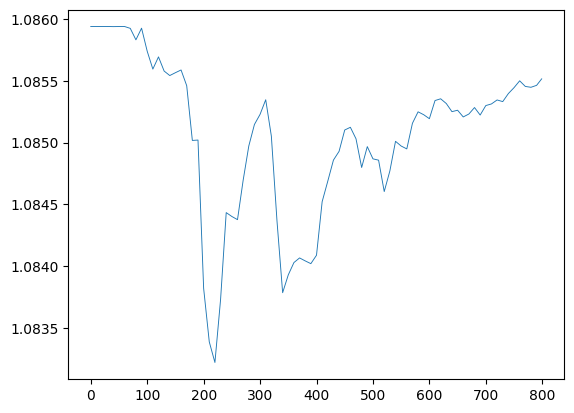

In [51]:
plt.close()
plt.plot(data.ts.iterations, [particle_weights_origin[idx] * p_witnessInsitu[step]['normalized_density_factor'] for idx,step in enumerate(data.ts.iterations)])
plt.show()

In [53]:
particle_weights_origin[0] * p_witnessInsitu[0]['normalized_density_factor']

array([1.0859381])

In [52]:
diag.total_charge(p_witnessInsitu[0])

array([1.0859381])

In [43]:
data.charge(q = diag.total_charge(p_witnessInsitu[0]))

array([1.16766424e-10])

In [68]:
x_total, w_total = data.ts.get_particle(species=spec, var_list = ['x','w'], iteration = 0)


In [102]:
w_total.sum()

np.float64(303353.8398018087)

In [113]:
# x_total.size * w_total[0]
# (x_total.size * constants.e * 1e12)
x_total.size * constants.e * (np.sum(p_witnessInsitu[0]['sum(w)']) * p_witnessInsitu[0]['normalized_density_factor'])

array([3.20224072e-11])

In [106]:
# np.sum(p_witnessInsitu[0]['sum(w)'])
# p_witnessInsitu[0]['normalized_density_factor']

np.sum(p_witnessInsitu[0]['sum(w)']) * p_witnessInsitu[0]['normalized_density_factor']

array([1.0859381])

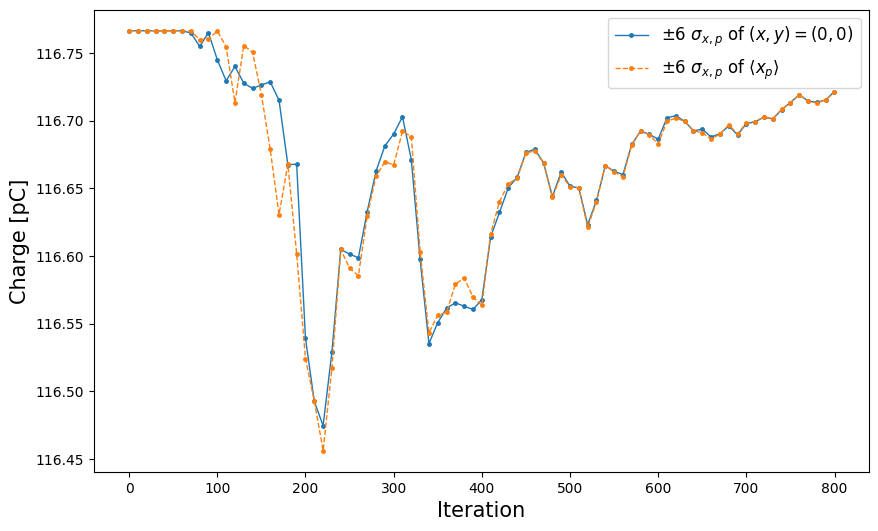

In [57]:
plt.close()
plt.figure(figsize = (10, 6))
plt.plot(data.ts.iterations, [ 1e12 * data.charge(q = particle_weights_origin[idx] * p_witnessInsitu[step]['normalized_density_factor']) for idx,step in enumerate(data.ts.iterations) ], label='$\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $(x,y)=(0,0)$', marker='o', markersize=2.5, ls='-', lw=1)
plt.plot(data.ts.iterations, [ 1e12 * data.charge(q = particle_weights_centroid[idx] * p_witnessInsitu[step]['normalized_density_factor']) for idx,step in enumerate(data.ts.iterations) ], label='$\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $\\langle x_p \\rangle$', marker='o', markersize=2.5, ls='--', lw=1)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Charge [pC]', fontsize=15)
# plt.ylabel('Particles within $\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $(x,y)=(0,0)$')

# sci()

plt.legend(fontsize=12)

plt.show()

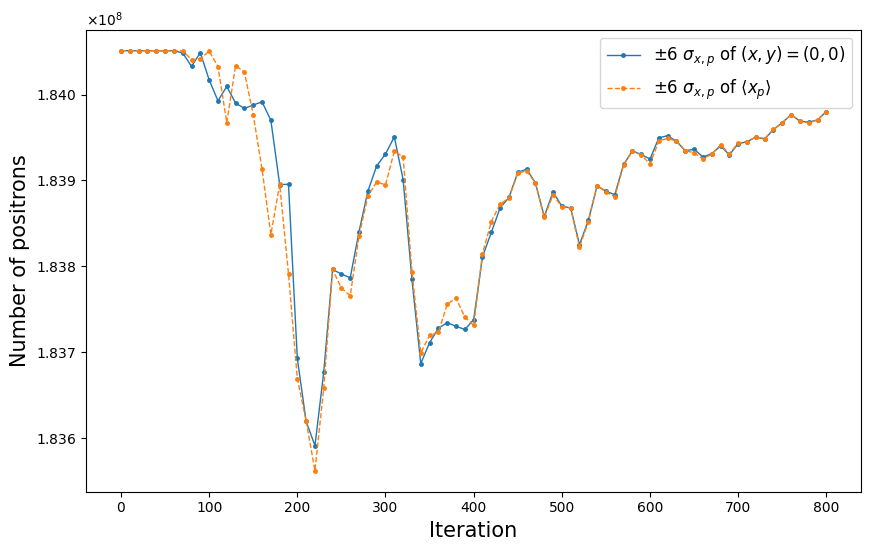

In [53]:
plt.close()
plt.figure(figsize = (10, 6))

plt.plot(data.ts.iterations, particle_count_origin, label='$\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $(x,y)=(0,0)$', marker='o', markersize=2.5, ls='-', lw=1)
plt.plot(data.ts.iterations, particle_count_centroid, label='$\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $\\langle x_p \\rangle$', marker='o', markersize=2.5, ls='--', lw=1)
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Number of positrons', fontsize=15)
# plt.ylabel('Particles within $\pm$' + f'{n}' + ' $\sigma_{x,p}$ of $(x,y)=(0,0)$')

sci()

plt.legend(fontsize=12)

plt.show()

In [33]:
lim = 0.18
increment = int(1000)
spec = 'witness'

for idx,iteration in enumerate(data.ts.iterations):
    print(iteration)

    x,y,z = data.ts.get_particle(species=spec, var_list = ['x','y','z'], iteration = iteration)

    plt.close()
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(15,10))
    
    ax.scatter(z[::increment], x[::increment], y[::increment], c='b', alpha=0.25, marker='o', s=2.5, edgecolors='none')
    
    # ax = sci(x=True)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_aspect('equal')
    # ax.set_aspect('equalyz')
    
    ax.set_xlabel('$k_p\\xi$', fontsize = 18)
    ax.set_ylabel('$k_px$', fontsize = 18)
    ax.set_zlabel('$k_py$', fontsize = 18)
    
    plt.title(f'Iteration = {iteration}')

    plt.savefig(f'/users/varverak/xyz_plots/{idx}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.close()

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
799


### XY

In [ ]:
spec = 'witness'
iterations = data.ts.iterations
len_iter = data.ts.iterations.size

x = { iteration: data.ts.get_particle(species=spec, var_list = ['x'], iteration = iteration) for iteration in iterations }
y = { iteration: data.ts.get_particle(species=spec, var_list = ['y'], iteration = iteration) for iteration in iterations }

# x,y = data.ts.get_particle(species=spec, var_list = ['x','y'], iteration = 20)

In [ ]:
lim = 0.1
spec = 'witness'
# iterations = data.ts.iterations

for iteration in data.ts.iterations[45:]:
    print(iteration)
    x,y = data.ts.get_particle(species=spec, var_list = ['x','y'], iteration = iteration)
    
    plt.close()
    plt.figure(figsize = (10, 6))
    
    plt.hist2d(x, y, bins=100, cmap=plt.cm.Blues, vmin=0, vmax=7e5)
    
    ax = sci(x=True)
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    ax.set_aspect(1)
    
    plt.xlabel(r'$k_px$', fontsize = 18)
    plt.ylabel(r'$k_py$', fontsize = 18)
    
    cb = plt.colorbar(pad=0.02, extend='max')
    cb.formatter.set_useMathText(True)
    cb.formatter.set_powerlimits((0, 0))
    cb.set_label('Particle density', fontsize=13)
    
    plt.title(f'Iteration = {iteration}')

    plt.savefig(f'/users/varverak/xy_plots/{iteration:03d}.png', dpi = 300, bbox_inches = 'tight')
    
    plt.close()

450
460
470
480
490


### Old vis

In [31]:
spec = 'witness'
iterations = data.ts.iterations

avg_x = [ np.mean(data.ts.get_particle(species=spec, var_list = ['x'], iteration = iteration)) for iteration in iterations ]
avg_y = [ np.mean(data.ts.get_particle(species=spec, var_list = ['y'], iteration = iteration)) for iteration in iterations ]    

In [35]:
p_driveInsitu = {step: data.diag.read_file(ip + f'reduced_drive.{step:04}.txt') for step in range(max_step)}
p_witnessInsitu = {step: data.diag.read_file(ip + f'reduced_witness.{step:04}.txt') for step in range(max_step)}
p_recoveryInsitu = {step: data.diag.read_file(ip + f'reduced_recovery.{step:04}.txt') for step in range(max_step)}
p_fieldInsitu = {step: data.diag.read_file(ip + f'reduced_fields.{step:04}.txt') for step in range(max_step)}
time = [p_driveInsitu[step]['time'] * data.kp_inv for step in range(max_step)]

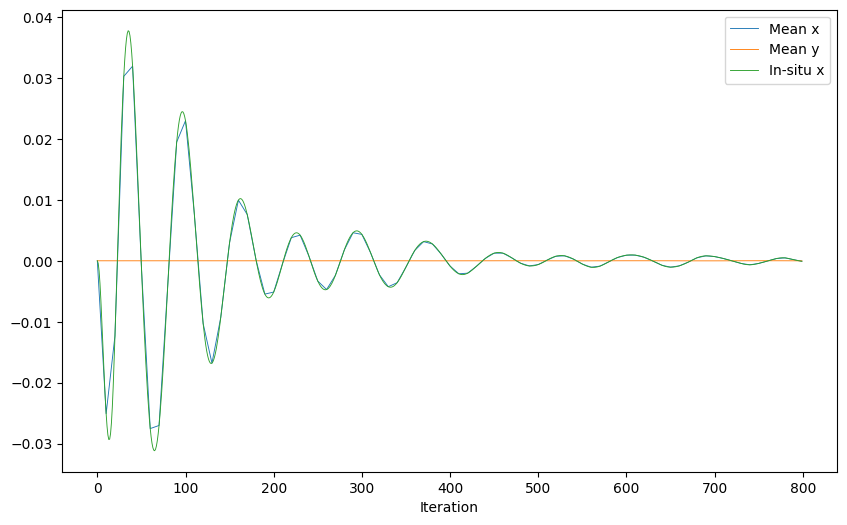

In [39]:
plt.close()
plt.figure(figsize = (10, 6))

plt.plot(iterations, avg_x, label='Mean x')
plt.plot(iterations, avg_y, label='Mean y')
plt.plot([i for i in range(max_step)], [p_witnessInsitu[step]['average']['[x]'] for step in range(max_step)], label = 'In-situ x')

plt.xlabel('Iteration')
plt.legend()

plt.show()

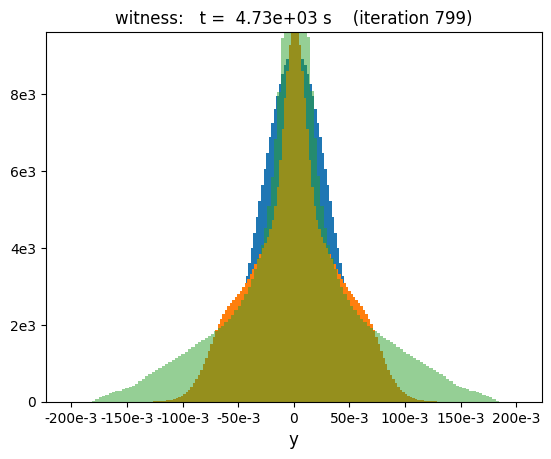

In [28]:
spec = 'witness'

data.ts.get_particle(species=spec, var_list = ['y'], iteration = 0, plot=True)
data.ts.get_particle(species=spec, var_list = ['y'], iteration = 50, plot=True)
data.ts.get_particle(species=spec, var_list = ['y'], iteration = max_step-1, plot=True, alpha=0.5)

plt.show()

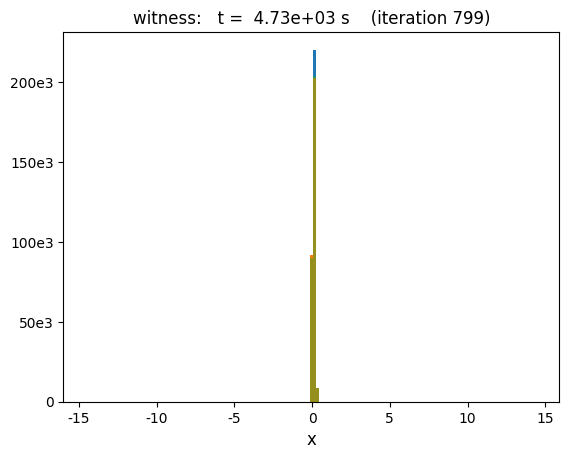

In [29]:
spec = 'witness'

data.ts.get_particle(species=spec, var_list = ['x'], iteration = 0, plot=True)
data.ts.get_particle(species=spec, var_list = ['x'], iteration = 50, plot=True)
data.ts.get_particle(species=spec, var_list = ['x'], iteration = max_step-1, plot=True, alpha=0.5)

plt.show()